# Final Project

Financial Data Science II

Fall 2021

Group Members:
* Junichi Koganemaru
* Bohang Wei
* Kaiyue Liao
* Peiwen Xiang
* Renjia Guo

## Guidelines

You should submit both your `.ipynb` file and a `.pdf` version of the notebook via Canvas.

We should be able to take your code, and easily run it. It can load standard Python packages, of course, but it should otherwise be self-contained, not reliant upon any other code.

This is to be completed in your groups. All group members should participate in, and understand, all aspects of the analysis.

**Different groups are not allowed to interact or in any way communicate regarding their analyses.**

We are not looking for a formal "report," but **explain what you are doing** and **state any conclusions in practical terms.** For example, do not just say "The p-value is 0.02." What does that mean in practical terms?

Visualizations will be graded, in part, on their readability. Make fonts sufficiently large. Do not label axes with things such as "CSCORE_B." Use readable names.

You can email me with questions. If it is relevant to the entire class, I will ask you to post it on the Discussion Board. Please do not post questions directly to the Discussion Board regarding this, however.

## The Data

We will continue using the Fannie Mae data set used in the Homeworks 2 and 3. Here we will use a different subset. Just as in Homework 2, it only contains loans for which there is a current unpaid balance, i.e. for which `CURRENT_UPB` is greater than zero.

This data file is available as `project.csv` on Canvas.

## Your Objective

Imagine that you are constructing a simulation model that will generate realistic-looking loans of the type shown in this data set. We will focus here on one particular aspect of this: Simulating credit scores.

Our focus will be on the column `CSCORE_B`.



## Specific Steps

1. There are four missing values in `CSCORE_B`. Fill them in by using the following procedure: Cluster the loans, and then determine which cluster each of the loans with the missing value belong to. Replace the missing credit score value with the average credit score of those observations in the same cluster. Of course, the procedure cannot use `CSCORE_B` as one of the variables used to cluster loans. You can use any clustering procedure of your choice.
2. Visualize the distribution of `CSCORE_B`. Comment on its shape.
3. Find a parametric model that fits to the distribution of `CSCORE_B`. You can consider any distribution you would like, as long as it is parametric. Justify your choice using visualization and AIC. As in any real-world problem, you should not expect the fit to be "perfect." Get the best-fitting parametric distribution that you can. Report the MLE of the parameters for this fit.
4. Visualize how the distribution of `CSCORE_B` varies over different property types, i.e., for different values of `PROP`. Does it seem that the distribution changes across the different values of `PROP`? (Just to be clear, when I say "the distribution changes" I mean any aspect of the distribution changes. For example, going from a Normal(10,2) distribution to a Normal(12,2) is a "change" in distribution.)
5. Is there strong evidence that the distribution of `CSCORE_B` varies across the different values of `PROP`? Test a relevant hypothesis, and report the p-value. This test should be performed using a likelihood ratio test.

## Grading

Each of the five steps listed above will be assessed and scored based on three elements: (1) Appropriate choice of method(s) of analysis and/or visualization, (2) correct implmentation of those method(s), and (3) valid interpretation of the results. Each of these three elements will be given equal weight, and the total points allocated to each step are as follows: Step 1, 18 points. Step 2, 6 points. Step 3, 15 points. Step 4, 6 points. Step 5, 18 points. This is a total of 63 points.

In addition, the notebooks will be assessed based on the overall quality of the visualizations (on a scale of 0 to 6 points) on the overall quality of practical explanations of results (on a scale of 0 to 6 points), and on overall organization of the notebook, i.e., can we find where the different steps are, etc., or is it a mess (on a scale of 0 to 5 points).

Hence, there are total of 80 points.

## Peer Assessment

This is everyone's least favorite part, but I have little choice but to incoporate some component of peer feedback, i.e. assessing how much your groupmates contributed to the work. Without this, I have little basis for avoiding problems where students let the work fall on their groupmates.

Any negative information found through this process will be investigated by the instructor.

I do reserve the right to adjust individual students' grades based on lack of engagement with the project.

The easy way to avoid any problems is to make sure that everyone is engaged and participating. Please advise me of any issues as soon as possible.

# Step 1

In [2]:
#Importing standard packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Installing nonstandard packages 
import sys
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install gowers

## Exploratory Data Analysis

### Loading data

In [4]:
#loading data
loandata = pd.read_csv('project.csv', sep = '|')

loandata.columns = ("POOL_ID", "LOAN_ID", "ACT_PERIOD", "CHANNEL", "SELLER", "SERVICER",
                        "MASTER_SERVICER", "ORIG_RATE", "CURR_RATE", "ORIG_UPB", "ISSUANCE_UPB",
                        "CURRENT_UPB", "ORIG_TERM", "ORIG_DATE", "FIRST_PAY", "LOAN_AGE",
                        "REM_MONTHS", "ADJ_REM_MONTHS", "MATR_DT", "OLTV", "OCLTV",
                        "NUM_BO", "DTI", "CSCORE_B", "CSCORE_C", "FIRST_FLAG", "PURPOSE",
                        "PROP", "NO_UNITS", "OCC_STAT", "STATE", "MSA", "ZIP", "MI_PCT",
                        "PRODUCT", "PPMT_FLG", "IO", "FIRST_PAY_IO", "MNTHS_TO_AMTZ_IO",
                        "DLQ_STATUS", "PMT_HISTORY", "MOD_FLAG", "MI_CANCEL_FLAG", "Zero_Bal_Code",
                        "ZB_DTE", "LAST_UPB", "RPRCH_DTE", "CURR_SCHD_PRNCPL", "TOT_SCHD_PRNCPL",
                        "UNSCHD_PRNCPL_CURR", "LAST_PAID_INSTALLMENT_DATE", "FORECLOSURE_DATE",
                        "DISPOSITION_DATE", "FORECLOSURE_COSTS", "PROPERTY_PRESERVATION_AND_REPAIR_COSTS",
                        "ASSET_RECOVERY_COSTS", "MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS",
                        "ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY", "NET_SALES_PROCEEDS",
                        "CREDIT_ENHANCEMENT_PROCEEDS", "REPURCHASES_MAKE_WHOLE_PROCEEDS",
                        "OTHER_FORECLOSURE_PROCEEDS", "NON_INTEREST_BEARING_UPB", "PRINCIPAL_FORGIVENESS_AMOUNT",
                        "ORIGINAL_LIST_START_DATE", "ORIGINAL_LIST_PRICE", "CURRENT_LIST_START_DATE",
                        "CURRENT_LIST_PRICE", "ISSUE_SCOREB", "ISSUE_SCOREC", "CURR_SCOREB",
                        "CURR_SCOREC", "MI_TYPE", "SERV_IND", "CURRENT_PERIOD_MODIFICATION_LOSS_AMOUNT",
                        "CUMULATIVE_MODIFICATION_LOSS_AMOUNT", "CURRENT_PERIOD_CREDIT_EVENT_NET_GAIN_OR_LOSS",
                        "CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS", "HOMEREADY_PROGRAM_INDICATOR",
                        "FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT", "RELOCATION_MORTGAGE_INDICATOR",
                        "ZERO_BALANCE_CODE_CHANGE_DATE", "LOAN_HOLDBACK_INDICATOR", "LOAN_HOLDBACK_EFFECTIVE_DATE",
                        "DELINQUENT_ACCRUED_INTEREST", "PROPERTY_INSPECTION_WAIVER_INDICATOR",
                        "HIGH_BALANCE_LOAN_INDICATOR", "ARM_5_YR_INDICATOR", "ARM_PRODUCT_TYPE",
                        "MONTHS_UNTIL_FIRST_PAYMENT_RESET", "MONTHS_BETWEEN_SUBSEQUENT_PAYMENT_RESET",
                        "INTEREST_RATE_CHANGE_DATE", "PAYMENT_CHANGE_DATE", "ARM_INDEX",
                        "ARM_CAP_STRUCTURE", "INITIAL_INTEREST_RATE_CAP", "PERIODIC_INTEREST_RATE_CAP",
                        "LIFETIME_INTEREST_RATE_CAP", "MARGIN", "BALLOON_INDICATOR",
                        "PLAN_NUMBER", "FORBEARANCE_INDICATOR", "HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR",
                        "DEAL_NAME", "RE_PROCS_FLAG", "ADR_TYPE", "ADR_COUNT", "ADR_UPB")


In [6]:
loandata.shape

(4999, 108)

In [7]:
loandata.head()

,POOL_ID,LOAN_ID,ACT_PERIOD,CHANNEL,SELLER,SERVICER,MASTER_SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,...,MARGIN,BALLOON_INDICATOR,PLAN_NUMBER,FORBEARANCE_INDICATOR,HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR,DEAL_NAME,RE_PROCS_FLAG,ADR_TYPE,ADR_COUNT,ADR_UPB
0,1443,33229873,1970-01-01 00:00:00.000082021,R,Other,Other,FANNIE MAE,3.875,3.875,105000.0,...,NaN,N,NaN,7,N,CAS 2016 C03 G2,NaN,7,NaN,NaN
1,1473,40837377,1970-01-01 00:00:00.000082021,C,Other,"Pingora Loan Servicing, LLC",FANNIE MAE,4.625,4.625,238000.0,...,NaN,N,NaN,7,N,CAS 2017 C03 G1,NaN,7,NaN,NaN
2,1474,41378070,1970-01-01 00:00:00.000082021,C,Truist Bank (formerly SunTrust Bank),Truist Bank (formerly SunTrust Bank),FANNIE MAE,3.750,3.750,409000.0,...,NaN,N,NaN,7,N,CAS 2017 C04 G2,NaN,7,NaN,NaN
3,5228,125559711,1970-01-01 00:00:00.000082021,R,Other,Other,FANNIE MAE,3.090,3.090,314000.0,...,NaN,N,NaN,7,N,CAS 2021 R01 G1,NaN,7,NaN,NaN
4,5124,94867529,1970-01-01 00:00:00.000082021,R,Other,Other,FANNIE MAE,4.250,4.250,232000.0,...,NaN,N,NaN,7,N,CAS 2020 R01 G1,NaN,7,NaN,NaN


In [5]:
#converting variables to appropraite datatype 
loandata['POOL_ID'] = loandata['POOL_ID'].astype("category")
loandata['LOAN_ID'] = loandata['LOAN_ID'].astype("category")
loandata['ZIP'] = loandata['ZIP'].astype("category")
loandata['ACT_PERIOD'] = loandata['ACT_PERIOD'].astype("datetime64[ns]")
loandata['ORIG_DATE'] = loandata['ORIG_DATE'].astype("datetime64[ns]")
loandata['FIRST_PAY'] = loandata['FIRST_PAY'].astype("datetime64[ns]")
loandata['MATR_DT'] = loandata['MATR_DT'].astype("datetime64[ns]")
loandata['FIRST_PAY_IO'] = loandata['FIRST_PAY_IO'].astype("datetime64[ns]")
loandata['Zero_Bal_Code'] = loandata['Zero_Bal_Code'].astype("category")
loandata['ZB_DTE'] = loandata['ZB_DTE'].astype("datetime64[ns]")
loandata['RPRCH_DTE'] = loandata['RPRCH_DTE'].astype("datetime64[ns]")
loandata['LAST_PAID_INSTALLMENT_DATE'] = loandata['LAST_PAID_INSTALLMENT_DATE'].astype("datetime64[ns]")
loandata['FORECLOSURE_DATE'] = loandata['FORECLOSURE_DATE'].astype("datetime64[ns]")
loandata['DISPOSITION_DATE'] = loandata['DISPOSITION_DATE'].astype("datetime64[ns]")
loandata['ORIGINAL_LIST_START_DATE'] = loandata['ORIGINAL_LIST_START_DATE'].astype("datetime64[ns]")
loandata['CURRENT_LIST_START_DATE'] = loandata['CURRENT_LIST_START_DATE'].astype("datetime64[ns]")
loandata['ZERO_BALANCE_CODE_CHANGE_DATE'] = loandata['ZERO_BALANCE_CODE_CHANGE_DATE'].astype("datetime64[ns]")
loandata['LOAN_HOLDBACK_EFFECTIVE_DATE'] = loandata['LOAN_HOLDBACK_EFFECTIVE_DATE'].astype("datetime64[ns]")
loandata['INTEREST_RATE_CHANGE_DATE'] = loandata['INTEREST_RATE_CHANGE_DATE'].astype("datetime64[ns]")
loandata['PAYMENT_CHANGE_DATE'] = loandata['PAYMENT_CHANGE_DATE'].astype("datetime64[ns]")

### Handling missing values

In [6]:
#Identifying columns with all missing values or mostly missing values
na_columns = []
for vals in loandata.columns:
    if (loandata[vals].isna().all()) or (loandata[vals].isna().sum() > 66):
        na_columns.append(vals)

In [9]:
len(na_columns)

61

In [7]:
#Dropping identified columns
X = loandata.drop(columns = na_columns)

#Dropping columns with 1 unique value
nunique = X.nunique()
cols_to_drop = nunique[nunique == 1].index
X = X.drop(cols_to_drop, axis=1)

In [59]:
loandata.sh

(4999, 108)

In [138]:
X.shape

(4999, 40)

In [8]:
#remaining columns 
X.columns 

Index(['POOL_ID', 'LOAN_ID', 'CHANNEL', 'SELLER', 'SERVICER', 'ORIG_RATE',
       'CURR_RATE', 'ORIG_UPB', 'ISSUANCE_UPB', 'CURRENT_UPB', 'ORIG_TERM',
       'ORIG_DATE', 'FIRST_PAY', 'LOAN_AGE', 'REM_MONTHS', 'ADJ_REM_MONTHS',
       'MATR_DT', 'OLTV', 'OCLTV', 'NUM_BO', 'CSCORE_B', 'FIRST_FLAG',
       'PURPOSE', 'PROP', 'NO_UNITS', 'OCC_STAT', 'STATE', 'MSA', 'ZIP',
       'DLQ_STATUS', 'PMT_HISTORY', 'MOD_FLAG', 'ISSUE_SCOREB', 'SERV_IND',
       'CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS',
       'RELOCATION_MORTGAGE_INDICATOR', 'HIGH_BALANCE_LOAN_INDICATOR',
       'FORBEARANCE_INDICATOR', 'DEAL_NAME', 'ADR_TYPE'],
      dtype='object')

In [16]:
missing = X[ X['CSCORE_B'].isnull() == True ]

In [17]:
missing.head()

,POOL_ID,LOAN_ID,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,...,PMT_HISTORY,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE
1772,5123,94259369,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",3.750,3.750,69000.0,36772.61,20602.03,...,000000000000000000000000000000000000000000000000,N,638.0,N,0.0,N,N,7,CAS 2019-HRP1,7
1933,1398,26909202,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",4.625,4.625,180000.0,176231.93,152852.86,...,000000000000000000000000000000000000000000000000,N,781.0,N,0.0,N,N,7,CAS 2015 C01 G2,7
3529,1484,43103805,R,Other,Other,3.625,3.625,120000.0,119070.60,108745.27,...,000000000000000000000000000000000000000000000000,N,806.0,N,0.0,N,N,7,CAS 2017 C05 G1,7
4759,5123,94576786,R,Other,Other,4.000,4.000,149000.0,73153.42,52627.71,...,000000000000000000000000000000000000000000000000,N,NaN,N,0.0,N,N,7,CAS 2019-HRP1,7


In [18]:
missing_columns = []
for vals in missing.columns:
    if (missing[vals].isna().any()):
        missing_columns.append(vals)

In [19]:
missing_columns

['NUM_BO', 'CSCORE_B', 'ISSUE_SCOREB']

In [68]:
X['CSCORE_B'].corr(X['NUM_BO'])

0.0823690995560387

In [64]:
X['NUM_BO'].isnull().sum()

1

<AxesSubplot:>

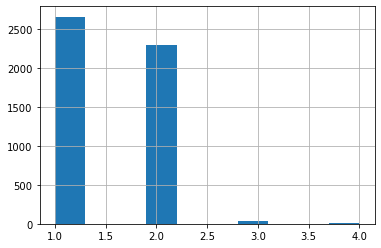

In [23]:
X['NUM_BO'].hist()

In [22]:
X['NUM_BO'].describe()

count    4998.000000
mean        1.478191
std         0.522291
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: NUM_BO, dtype: float64

In [10]:
X['NUM_BO'] = X['NUM_BO'].fillna(-1)

In [70]:
X['CSCORE_B'].corr(X['ISSUE_SCOREB'])

0.6943425775597027

In [71]:
X['ISSUE_SCOREB'].isnull().sum()

57

In [29]:
X['ISSUE_SCOREB'].describe()

count    4942.000000
mean      752.033590
std        53.856117
min       450.000000
25%       721.000000
50%       768.000000
75%       794.000000
max       818.000000
Name: ISSUE_SCOREB, dtype: float64

<AxesSubplot:>

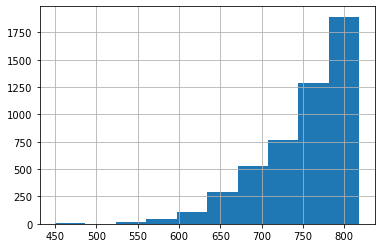

In [28]:
X['ISSUE_SCOREB'].hist()

In [9]:
mean = X['ISSUE_SCOREB'].mean()
X.loc[X['LOAN_ID'] == 94576786, 'ISSUE_SCOREB'] = X.loc[X['LOAN_ID'] == 94576786, 'ISSUE_SCOREB'].fillna(mean)

In [77]:
missing2 = X[ X['LOAN_ID'].isin([94259369,26909202, 43103805, 94576786]) ]

In [78]:
missing2['NUM_BO']

1772    2.0
1933    2.0
3529    2.0
4759   -1.0
Name: NUM_BO, dtype: float64

In [79]:
missing2['ISSUE_SCOREB']

1772    638.00000
1933    781.00000
3529    806.00000
4759    752.03359
Name: ISSUE_SCOREB, dtype: float64

In [11]:
X = X.drop(columns = ['POOL_ID', 'ZIP', 'ORIG_DATE'])
#X = X.dropna(subset = X.columns.difference(['CSCORE_B']), how = 'all')

In [12]:
X = X.dropna(subset = X.columns.difference(['CSCORE_B']), how = 'any')

In [14]:
X.shape

(4901, 37)

In [13]:
CreditScoreB = X['CSCORE_B']
X_withoutID = X.drop(columns = ['LOAN_ID', 'CSCORE_B'])

In [146]:
X_withoutID.head()

,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,ORIG_TERM,FIRST_PAY,...,PMT_HISTORY,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE
0,R,Other,Other,3.875,3.875,105000.0,103725.97,91736.60,360,1970-01-01 00:00:00.000052015,...,000000000000000000000000000000000000000000000000,N,807.0,N,0.0,N,N,7,CAS 2016 C03 G2,7
1,C,Other,"Pingora Loan Servicing, LLC",4.625,4.625,238000.0,234629.13,211659.69,360,1970-01-01 00:00:00.000082016,...,000000000000000000000000000000000000000000000000,N,618.0,N,0.0,N,N,7,CAS 2017 C03 G1,7
2,C,Truist Bank (formerly SunTrust Bank),Truist Bank (formerly SunTrust Bank),3.750,3.750,409000.0,406027.37,370177.64,360,1970-01-01 00:00:00.000122016,...,000000000000000000000000000000000000000000000000,N,776.0,N,0.0,N,N,7,CAS 2017 C04 G2,7
3,R,Other,Other,3.090,3.090,314000.0,309175.28,309175.28,360,1970-01-01 00:00:00.000122020,...,XXXXXXXXXXXXXXXXXXXXXXXXXXXX00000000000000000000,N,817.0,N,0.0,N,N,7,CAS 2021 R01 G1,7
4,R,Other,Other,4.250,4.250,232000.0,230000.00,223310.96,360,1970-01-01 00:00:00.000072019,...,000000000000000000000000000000000000000000000000,N,805.0,N,0.0,N,N,7,CAS 2020 R01 G1,7


In [147]:
X_withoutID.shape

(4901, 35)

### Data Visualization

In [14]:
import gower

In [15]:
#Calculating distance matrix w.r.t. Gowers similarity metric
dist_matrix = gower.gower_matrix(X_withoutID)

In [149]:
dist_matrix.shape

(4901, 4901)

In [30]:
#Using tSNE and UMAP for nonlinear dimension reduction
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [31]:
X_tsne = TSNE(n_components=2, metric = 'precomputed').fit_transform(dist_matrix)
X_umap = umap.UMAP(metric = 'precomputed').fit_transform(dist_matrix)

/Users/junichikoganemaru/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/junichikoganemaru/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Text(0, 0.5, 'tSNE 2')

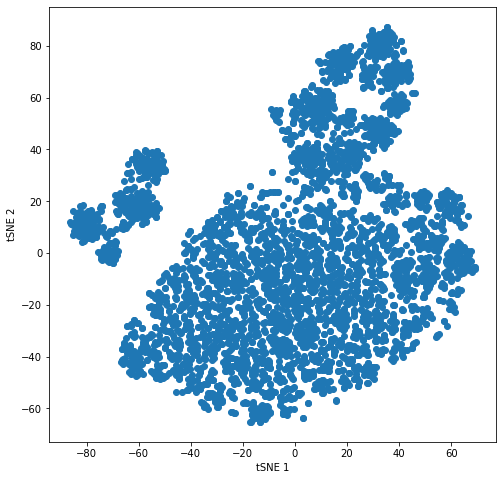

In [151]:
plt.figure(figsize=(8,8))
plt.scatter(X_tsne [:,0],X_tsne [:,1])
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')

Text(0, 0.5, 'umap 2')

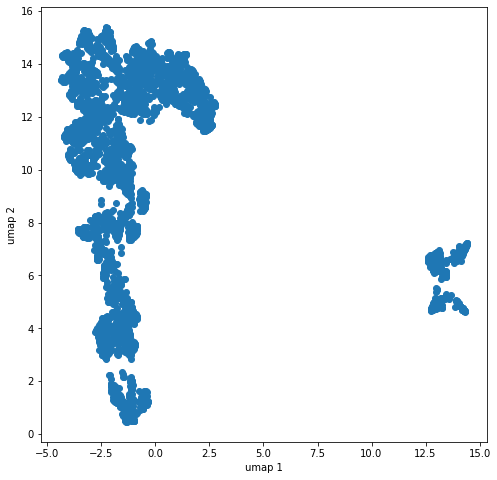

In [152]:
plt.figure(figsize=(8,8))
plt.scatter(X_umap[:,0],X_umap[:,1])
plt.xlabel('umap 1')
plt.ylabel('umap 2')

## Clustering

In [27]:
#Clustering using AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

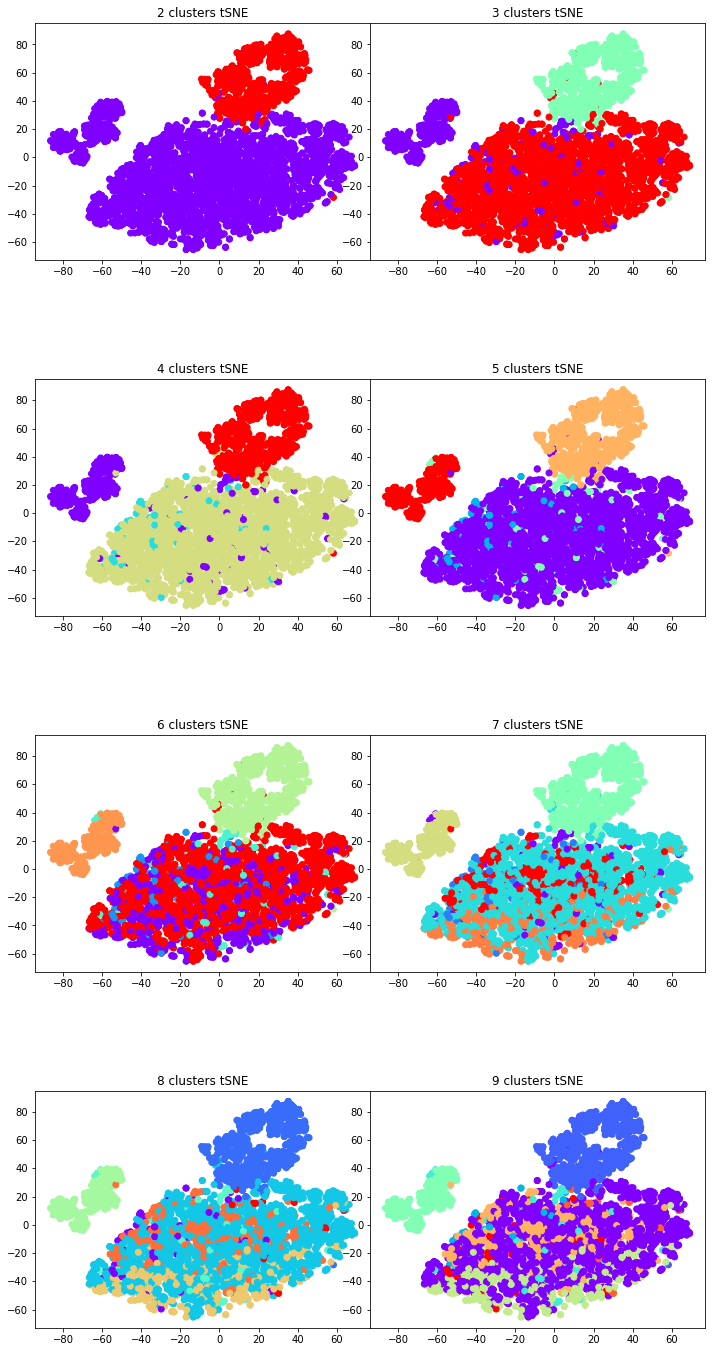

In [153]:
#Comibing plots with differet number of clusters, visualizing with tSNE
fig = plt.figure
fig, axs = plt.subplots(4,2, figsize=(12, 24))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for k in range(2,10):
    clustering_Agglomerative = AgglomerativeClustering(n_clusters = k, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)
    axs[k-2].scatter(X_tsne[:,0],X_tsne[:,1], c = clustering_Agglomerative.labels_, cmap='rainbow')
    axs[k-2].set_title(str(k)+' clusters tSNE')

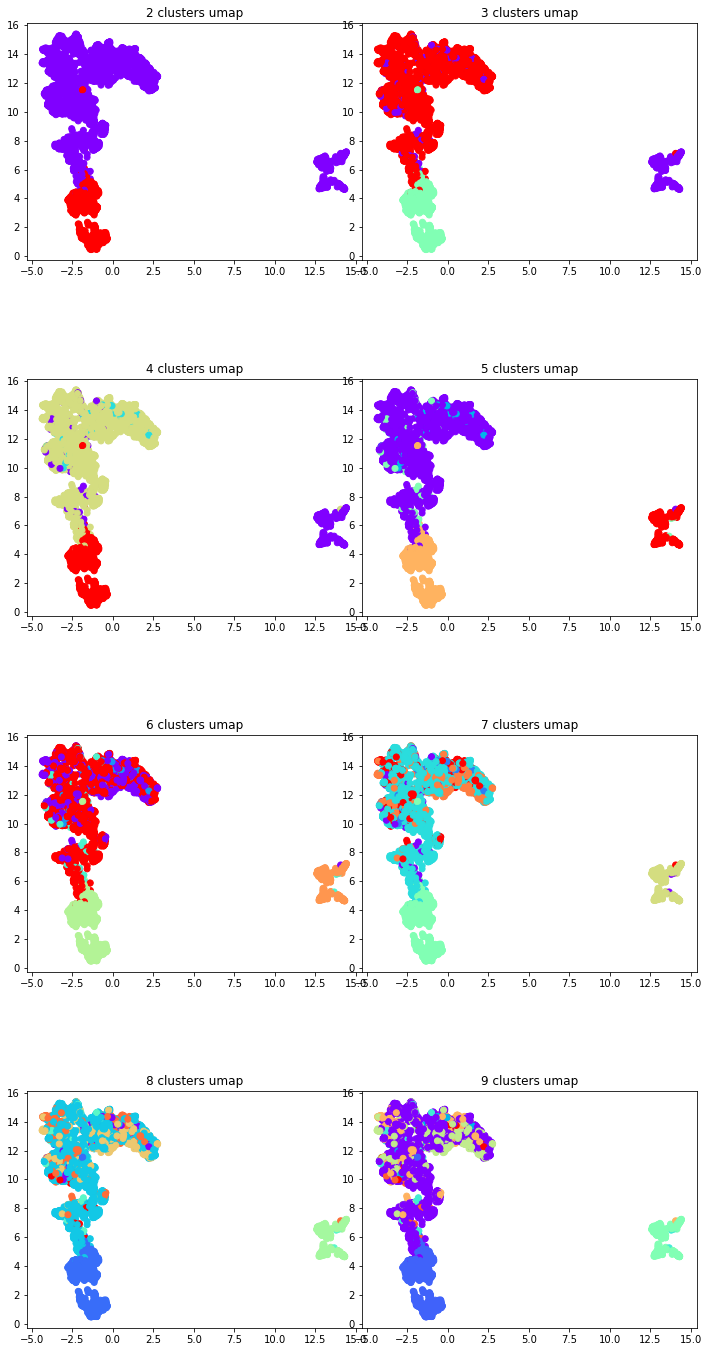

In [154]:
#Comibing plots with differet number of clusters, visualizing with UMAP
fig = plt.figure
fig, axs = plt.subplots(4,2, figsize=(12, 24))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for k in range(2,10):
    clustering_Agglomerative = AgglomerativeClustering(n_clusters = k, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)
    axs[k-2].scatter(X_umap[:,0],X_umap[:,1], c = clustering_Agglomerative.labels_, cmap='rainbow')
    axs[k-2].set_title(str(k)+' clusters umap')

In [18]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

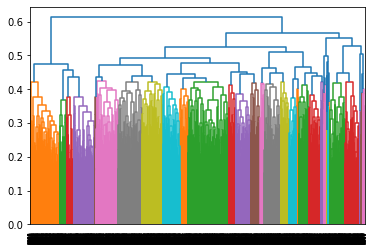

In [25]:
condensed_dist_matrix = squareform(dist_matrix)
Z = hierarchy.linkage(condensed_dist_matrix, 'complete')
plt.figure()
dn = hierarchy.dendrogram(Z)

The dendrogram seems to suggest that cutting somewhere between 0.5 and 0.6 would be a good choice. The result should be around 4 or 5 clusters. 

In [65]:
from sklearn.metrics import silhouette_score

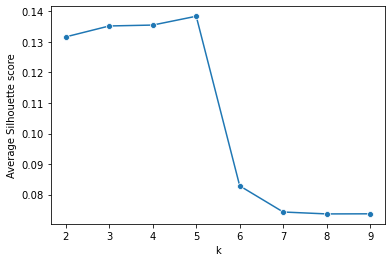

In [68]:
silhouette_scores = []

for k in range(2,10):
    clustering_Agglomerative = AgglomerativeClustering(n_clusters = k, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)
    silhouette_scores.append(silhouette_score(dist_matrix, clustering_Agglomerative.labels_, metric = 'precomputed'))
    
sns.lineplot(x = range(2,10), y = silhouette_scores, marker = 'o')
plt.xlabel('k')
plt.ylabel('Average Silhouette score')
plt.show()

We also compared the average Silhouette scores of each cluster even though the clustering method we chose isn't centroid based. Based on both the dendrogram and the average Silhouette scores we decided on working with 5 clusters.

In [28]:

clustering = AgglomerativeClustering(n_clusters = 5, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)

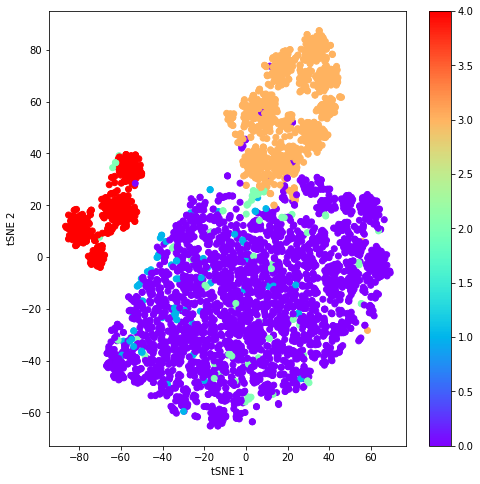

In [156]:
plt.figure(figsize=(8,8))
plt.scatter(X_tsne [:,0],X_tsne [:,1], c = clustering.labels_, cmap='rainbow')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.colorbar()

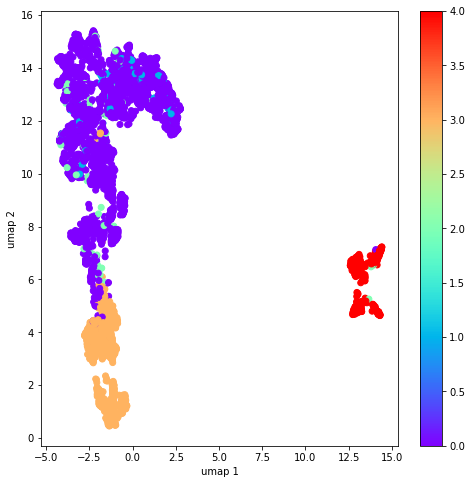

In [157]:
plt.figure(figsize=(8,8))
plt.scatter(X_umap [:,0],X_umap [:,1], c = clustering.labels_, cmap='rainbow')
plt.xlabel('umap 1')
plt.ylabel('umap 2')
plt.colorbar()

## Replacing Credit Score value with Clustering results 

In [29]:
#Adding cluster labels in the filtered data frame  
X['ClusterId'] = pd.Series(clustering.labels_, X.index)

In [80]:
X.head()

,LOAN_ID,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,ORIG_TERM,...,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE,ClusterId
0,33229873,R,Other,Other,3.875,3.875,105000.0,103725.97,91736.60,360,...,N,807.0,N,0.0,N,N,7,CAS 2016 C03 G2,7,0
1,40837377,C,Other,"Pingora Loan Servicing, LLC",4.625,4.625,238000.0,234629.13,211659.69,360,...,N,618.0,N,0.0,N,N,7,CAS 2017 C03 G1,7,0
2,41378070,C,Truist Bank (formerly SunTrust Bank),Truist Bank (formerly SunTrust Bank),3.750,3.750,409000.0,406027.37,370177.64,360,...,N,776.0,N,0.0,N,N,7,CAS 2017 C04 G2,7,0
3,125559711,R,Other,Other,3.090,3.090,314000.0,309175.28,309175.28,360,...,N,817.0,N,0.0,N,N,7,CAS 2021 R01 G1,7,4
4,94867529,R,Other,Other,4.250,4.250,232000.0,230000.00,223310.96,360,...,N,805.0,N,0.0,N,N,7,CAS 2020 R01 G1,7,0


In [106]:
X.shape

(4897, 38)

In [30]:
toreplace = X[ X['LOAN_ID'].isin([94259369,26909202, 43103805, 94576786]) ]

In [31]:
cluster0 = X[X['ClusterId'] == 0]
cluster1 = X[X['ClusterId'] == 1]
cluster2 = X[X['ClusterId'] == 2]
cluster3 = X[X['ClusterId'] == 3]
cluster4 = X[X['ClusterId'] == 4]

In [84]:
print(cluster0.shape)
print(cluster1.shape)
print(cluster2.shape)
print(cluster3.shape)
print(cluster4.shape)

(3344, 38)
(82, 38)
(75, 38)
(952, 38)
(448, 38)


In [89]:
toreplace

,LOAN_ID,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,ORIG_TERM,...,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE,ClusterId
1772,94259369,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",3.750,3.750,69000.0,36772.61,20602.03,180,...,N,638.00000,N,0.0,N,N,7,CAS 2019-HRP1,7,3
1933,26909202,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",4.625,4.625,180000.0,176231.93,152852.86,360,...,N,781.00000,N,0.0,N,N,7,CAS 2015 C01 G2,7,0
3529,43103805,R,Other,Other,3.625,3.625,120000.0,119070.60,108745.27,360,...,N,806.00000,N,0.0,N,N,7,CAS 2017 C05 G1,7,0
4759,94576786,R,Other,Other,4.000,4.000,149000.0,73153.42,52627.71,180,...,N,752.03359,N,0.0,N,N,7,CAS 2019-HRP1,7,3


In [32]:
mean0 = cluster0['CSCORE_B'].mean()
mean3 = cluster3['CSCORE_B'].mean()

X_filled = X 

X_filled.loc[X_filled['LOAN_ID'] == 94259369, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 94259369, 'CSCORE_B'].fillna(mean3)
X_filled.loc[X_filled['LOAN_ID'] == 26909202, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 26909202, 'CSCORE_B'].fillna(mean0)
X_filled.loc[X_filled['LOAN_ID'] == 43103805, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 43103805, 'CSCORE_B'].fillna(mean0)
X_filled.loc[X_filled['LOAN_ID'] == 94576786, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 94576786, 'CSCORE_B'].fillna(mean3)

In [97]:
X_filled['CSCORE_B'].isnull().any()

False

# Step 2 

<AxesSubplot:>

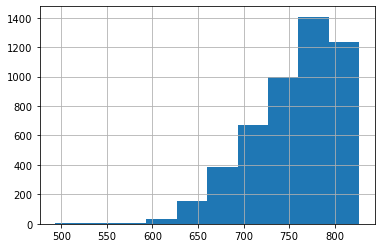

In [33]:
X_filled['CSCORE_B'].hist()

# Step 3

In [65]:
import scipy.stats

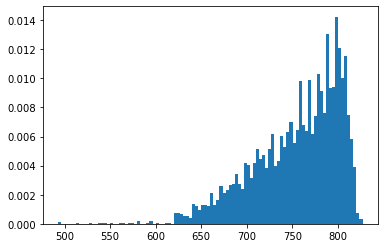

In [109]:
h = plt.hist(X_filled['CSCORE_B'].values.flatten(), bins=100, density = True)

In [55]:
y = creditscore_scaled

In [142]:
parameters = scipy.stats.norm.fit(y)
parameters


(755.2882114828855, 47.26673106846285)

/Users/junichikoganemaru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/junichikoganemaru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/Users/junichikoganemaru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/Users/junichikoganemaru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


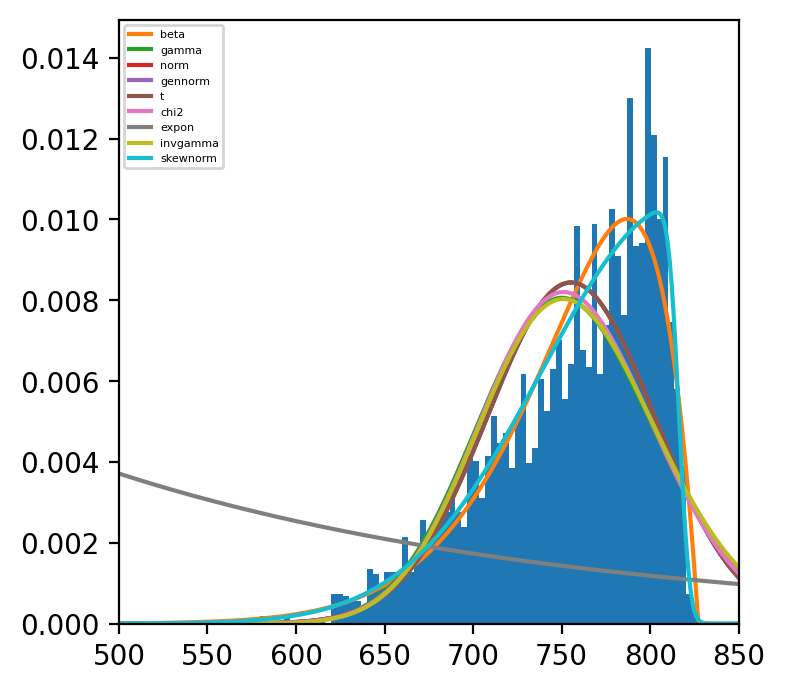

In [173]:
plt.figure(figsize=(4, 4), dpi=200)
N = len(X_filled['CSCORE_B'].values.flatten())
x = np.arange(N)
y = X_filled['CSCORE_B']
h = plt.hist(y.values.flatten(), bins=100, density = True)

#look most similar/try the distribution in lecture notes 
sample_distributions = ['beta', 'gamma', 'norm', 'gennorm', 't', 'chi2', 'expon', 'invgamma', 'skewnorm']
for distributions in sample_distributions:
    distribution = getattr(scipy.stats, distributions)
    parameters = distribution.fit(y)
    args = parameters[:-2]
    floc = parameters[-2]
    fscale = parameters[-1]
    if len(args) > 0:
        pdf = distribution.pdf(x, *args, loc=floc, scale=fscale) 
    else:
        pdf = distribution.pdf(x, loc=floc, scale=fscale) 
    
    plt.plot(pdf, label=distributions)
    plt.xlim(500,850)

plt.legend( prop={"size":4})
plt.show()

In [149]:
y.describe()

count    4901.000000
mean      755.288211
std        47.271554
min       493.000000
25%       725.000000
50%       766.000000
75%       794.000000
max       827.000000
Name: CSCORE_B, dtype: float64

In [154]:
for distributions in sample_distributions:
    np.seterr(divide = 'ignore') 
    distribution = getattr(scipy.stats, distributions)
    parameters = distribution.fit(y)
    args = parameters[:-2]
    floc = parameters[-2]
    fscale = parameters[-1]
    if len(args) > 0:
        aic = -2*np.sum(distribution.logpdf(y, *args, loc = floc, scale = fscale)) + 2*(len(parameters)-2)
        print(str(distributions) + 'AIC: ' + str(aic))
    else:
        aic = -2*np.sum(distribution.logpdf(y, loc = floc, scale = fscale)) + 2*(len(parameters)-2)
        print(str(distributions) + 'AIC: ' + str(aic))


betaAIC: 50261.0789105931
gammaAIC: 51993.00561124101
normAIC: 51703.052657751825
gennormAIC: 51705.05257334963
tAIC: 51705.03658730893
chi2AIC: 51940.99855912439
exponAIC: 64393.689529129624
invgammaAIC: 52056.852841696615
skewnormAIC: 50130.65453654797


In [183]:
scipy.stats.skewnorm.fit(y)

(-16.553803334678822, 816.2111976758019, 77.1087040200544)

# Step 4

In [164]:
X['PROP'].value_counts()

SF    3277
PU    1079
CO     464
MH      52
CP      29
Name: PROP, dtype: int64

In [166]:
X_SF = X[ X['PROP'] == "SF"]
X_PU = X[ X['PROP'] == "PU"]
X_CO = X[ X['PROP'] == "CO"]
X_MH = X[ X['PROP'] == "MH"]
X_CP = X[ X['PROP'] == "CP"]


<AxesSubplot:>

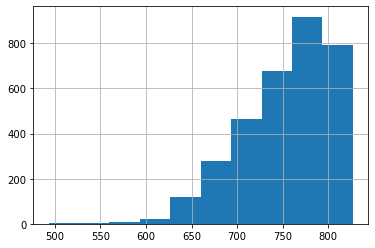

In [167]:
X_SF['CSCORE_B'].hist()

<AxesSubplot:>

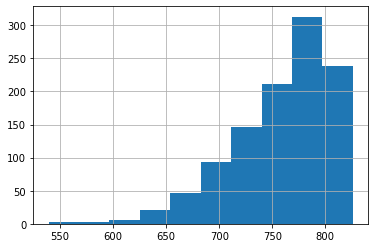

In [168]:
X_PU['CSCORE_B'].hist()

<AxesSubplot:>

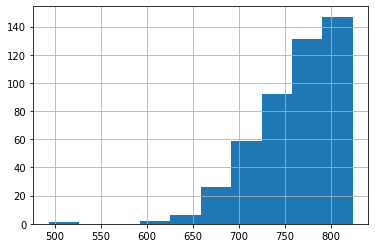

In [169]:
X_CO['CSCORE_B'].hist()

<AxesSubplot:>

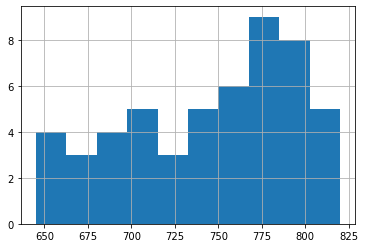

In [174]:
X_MH['CSCORE_B'].hist()

<AxesSubplot:>

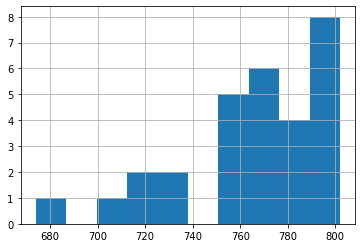

In [175]:
X_CP['CSCORE_B'].hist()

# Step 5